# 🔬 GenAI Scientific QA Pipeline (Hackathon-Ready)

This notebook extracts research abstracts from PubMed, summarizes them, and answers domain-specific questions using an open LLM (`flan-t5-base`).

In [3]:
# ✅ Install dependencies
!pip install -q biopython transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platfo

In [4]:
!pip install -q openai arxiv wikipedia sentence-transformers langchain matplotlib langchain-community

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [5]:
import requests
import arxiv
import wikipedia
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage

In [23]:
# 🔍 PubMed abstract retriever using Biopython
from Bio import Entrez
import pandas as pd

def fetch_pubmed_articles(query, start_year=2015, end_year=2024, max_results=20):
    Entrez.email = "nida.amir0083@gmail.com"  # Replace with your email
    handle = Entrez.esearch(db="pubmed", term=query,
                            mindate=f"{start_year}/01/01", maxdate=f"{end_year}/12/31",
                            retmax=max_results)
    record = Entrez.read(handle)
    ids = record["IdList"]

    abstracts = []
    sources = []
    handle = Entrez.efetch(db="pubmed", id=ids, rettype="abstract", retmode="text")
    for abstract in handle.read().split("\n\n"):
        clean_abstract = abstract.strip()
        if len(clean_abstract) > 100:
            abstracts.append(clean_abstract)
            sources.append("PubMed")  # Add source

    return pd.DataFrame({"abstract": abstracts, "source": sources})


In [24]:
# 📥 Fetch abstracts
query = "AI for Thyroid Cancer treatment and diagnosis"
df = fetch_pubmed_articles(query, max_results=20)
df.head(20)

,abstract,source
0,Attention-based image segmentation and classif...,PubMed
1,"Jassal K(1)(2), Di Muzio B(3), Edwards M(4), B...",PubMed
2,Author information:\n(1)Monash University Endo...,PubMed
3,BACKGROUND: Despite widespread use of standard...,PubMed
4,Author information:\n(1)Department of General ...,PubMed
5,Breast cancer is the most prevalent malignant ...,PubMed
6,Conflict of interest statement: Declaration of...,PubMed
7,3. Int J Radiat Oncol Biol Phys. 2024 Dec 19:S...,PubMed
8,Artificial Intelligence-Empowered Multistep In...,PubMed
9,"Yang YX(1), Yang X(1), Jiang XB(1), Lin L(1), ...",PubMed


In [25]:
# 🤖 Load open-access LLM (Flan-T5)
from transformers import pipeline
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")

Device set to use cuda:0


In [26]:
def get_wikipedia_background(topic):

    try:
        summary = wikipedia.summary(topic, sentences=5)
        return [{"source": "Wikipedia", "title": topic, "date" : topic, "summary": summary}]
    except Exception:
        return []

In [27]:
query1 = "AI for Thyroid Cancer treatment and diagnosis"
df1 = get_wikipedia_background(query1)
df1 = pd.DataFrame(df1)

In [28]:
def fetch_arxiv_articles(query, max_results=5):
    search = arxiv.Search(query=query, max_results=max_results, sort_by=arxiv.SortCriterion.Relevance)

    articles = []
    for result in search.results():
        published_year = result.published.year
        if published_year >= 2015 and published_year <= 2024:
            articles.append({"source": "arXiv", "title": result.title, "date": result.published, "summary": result.summary})
    return articles

In [29]:
query2 = "AI for Thyroid Cancer treatment and diagnosis"
df2 = fetch_arxiv_articles(query, max_results=20)
df2 = pd.DataFrame(df2)
df2.head(20)

<ipython-input-28-180c7f4b2dfc>:5: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():


,source,title,date,summary
0,arXiv,"AI in Thyroid Cancer Diagnosis: Techniques, Tr...",2023-08-25 17:27:53+00:00,There has been a growing interest in creating ...
1,arXiv,A systematic review on the role of artificial ...,2020-06-10 14:38:05+00:00,"Thyroid cancer is common worldwide, with a rap..."
2,arXiv,Advancements in Radiomics and Artificial Intel...,2024-04-09 11:05:20+00:00,Thyroid cancer is an increasing global health ...
3,arXiv,Improving The Diagnosis of Thyroid Cancer by M...,2022-03-27 17:37:18+00:00,Thyroid cancer is a common endocrine carcinoma...
4,arXiv,From Data to Insights: A Comprehensive Survey ...,2024-01-08 08:10:37+00:00,"Thyroid cancer, the most prevalent endocrine c..."
5,arXiv,Machine Learning and Transformers for Thyroid ...,2024-03-17 17:45:04+00:00,The growing interest in developing smart diagn...
6,arXiv,Personalized Diagnostic Tool for Thyroid Cance...,2022-07-01 15:32:47+00:00,"Over the past decades, the incidence of thyroi..."
7,arXiv,An Explainable AI Model for Predicting the Rec...,2024-10-13 23:12:33+00:00,"Thyroid carcinoma, a significant yet often con..."
8,arXiv,From Pixel to Slide image: Polarization Modali...,2024-01-03 02:01:09+00:00,Thyroid cancer is the most common endocrine ma...
9,arXiv,Thyroid Cancer Malignancy Prediction From Whol...,2019-03-29 17:47:28+00:00,We consider preoperative prediction of thyroid...


In [30]:
def build_merged_report(topic, pubmed_limit=5, arxiv_limit=5):
    pubmed = fetch_pubmed_articles(topic, max_results=pubmed_limit)
    arxiv_articles = fetch_arxiv_articles(topic, max_results=arxiv_limit)
    wiki = get_wikipedia_background(topic)
    return pubmed.to_dict('records') + arxiv_articles + wiki

In [31]:
# 🧠 Ask a scientific question
def ask_scientific_question(question, context):
    prompt = f"Context: {context}\n\nQuestion: {question}"
    result = qa_pipeline(prompt, max_new_tokens=300)[0]["generated_text"]
    return result.strip()

# 🔍 Sample context and question
# Change is on this line:
context = " ".join(df["abstract"].tolist() + (df1["summary"].tolist() if "summary" in df1 else[]) + df2["summary"].dropna().tolist())[:4000]
question = "What AI tools are used in the diagnosis of Thyroid cancer?"
answer = ask_scientific_question(question, context)
print("🤖 Answer:", answer)

Token indices sequence length is longer than the specified maximum sequence length for this model (914 > 512). Running this sequence through the model will result in indexing errors


🤖 Answer: Attention-based image segmentation and classification model


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_results(data):
    # Ensure 'source' key exists in all
    for doc in data:
        if 'source' not in doc:
            if 'abstract' in doc:
                doc['source'] = 'PubMed'
            else:
                doc['source'] = 'Unknown'

    df = pd.DataFrame(data)
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x='source', order=df['source'].value_counts().index, palette='pastel')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.title("Source Distribution")
    plt.xlabel("Source")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


query: AI TOOLS USED FOR THYROID CANCER DIAGNOSIS


<ipython-input-28-180c7f4b2dfc>:5: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
<ipython-input-36-9cdf9691a1f5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='source', order=df['source'].value_counts().index, palette='pastel')


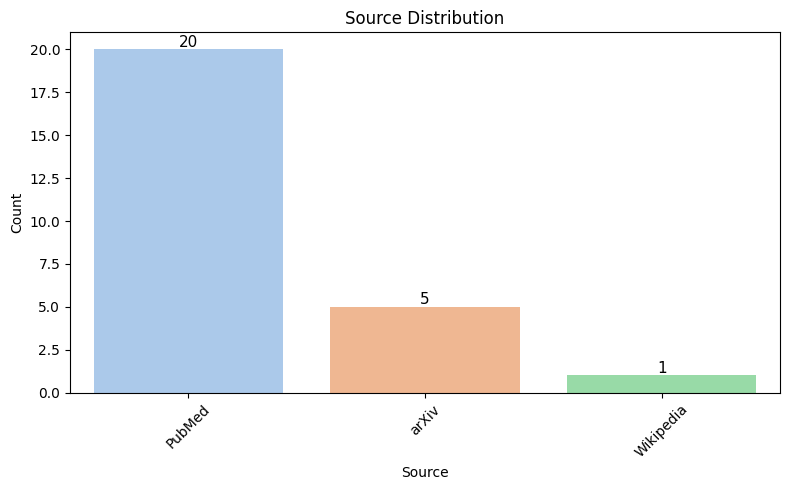



📚 Sources Fetched:
- PubMed: Artificial intelligence in cytopathological applications for
- PubMed: Author information:
(1)Hays Documentation Specialists, LLC, 
- PubMed: BACKGROUND: Cytopathological examination serves as a tool fo
- PubMed: Conflict of interest statement: Declarations Ethical approva
- PubMed: 2. Eur Urol Oncol. 2024 Nov 14:S2588-9311(24)00248-7. doi: 

- PubMed: A Systematic Review of the Diagnostic Accuracy of Deep Learn
- PubMed: Molière S(1), Hamzaoui D(2), Ploussard G(3), Mathieu R(4), F
- PubMed: Author information:
(1)Department of Radiology, Hôpital de H
- PubMed: BACKGROUND AND OBJECTIVE: Magnetic resonance imaging (MRI) p
- PubMed: DEL-Thyroid: deep ensemble learning framework for detection 
- PubMed: Author information:
(1)Center of Excellence in Artificial In
- PubMed: Genes, expressed as sequences of nucleotides, are susceptibl
- PubMed: 4. Lancet Digit Health. 2024 Jul;6(7):e458-e469. doi: 
10.10
- PubMed: Deep learning models for thyroid nodules diagn

In [43]:
if __name__ == "__main__":
    topic = input("query: ")
    merged_data = build_merged_report(topic)
    visualize_results(merged_data)

    print("\n\n📚 Sources Fetched:")
    sources = []
    for doc in merged_data:
        source_info = ""
        if 'source' in doc and 'title' in doc:
            source_info = f"- {doc['source']}: {doc['title'][:60]}"
        elif 'abstract' in doc:
            source_info = f"- PubMed: {doc['abstract'][:60]}"
        elif 'summary' in doc:
            source_info = f"- {doc.get('source', '')}: {doc['summary'][:60]}"

        if source_info:
            print(source_info)
            sources.append(doc)

    print("\n\n🧠 Evidence-Based Summary:")

    if not sources:
        print("No relevant sources found to generate summary.")
    else:
        # Extract key findings with better error handling
        key_findings = []
        for doc in sources:
            try:
                text = doc.get('summary', '') or doc.get('abstract', '') or doc.get('text', '') or ""
                if len(text) > 50:  # Only process if sufficient text exists
                    prompt = (
                        f"Extract one key finding about {topic} from this research, "
                        f"focusing on AI applications. Include specific numbers if available:\n{text[:1500]}"
                    )
                    result = qa_pipeline(prompt, max_new_tokens=120)[0]["generated_text"]
                    if topic.lower() in result.lower():  # Only keep relevant findings
                        key_findings.append(result.strip())
            except Exception as e:
                print(f"Error processing one source: {str(e)[:50]}...")
                continue

        if len(key_findings) >= 3:  # Only generate summary if enough quality findings
            # Generate structured summary
            summary_prompt = (
                "Synthesize these research findings into a cohesive paragraph about AI in thyroid cancer:\n"
                "1. Start with diagnostic applications\n"
                "2. Then discuss treatment/predictive applications\n"
                "3. Conclude with limitations/future directions\n"
                "Include specific performance metrics when available:\n\n"
                + "\n".join(f"- {f}" for f in key_findings)
            )

            try:
                final_summary = qa_pipeline(summary_prompt, max_new_tokens=650)[0]["generated_text"]
                # Post-process to improve quality
                final_summary = final_summary.replace("The text states that", "").replace("According to the article", "")
                print("\n" + final_summary + "\n")
            except Exception as e:
                print(f"Summary generation failed: {str(e)[:50]}...")
                print("\nKey findings instead:\n" + "\n".join(f"- {f}" for f in key_findings))
        else:
            print("Insufficient quality findings to generate comprehensive summary.")
            if key_findings:
                print("\nPartial findings:\n" + "\n".join(f"- {f}" for f in key_findings))